**Interconnect Telecom Operator**
---

### Introduction
---
This project aims to analyze customer churn for Interconnect Telecom Operator by leveraging machine learning techniques to identify key factors influencing attrition and develop targeted retention strategies. The process involved multiple stages, including data preprocessing, exploratory data analysis (EDA), model training, validation, and final evaluation. Given the raw data inconsistencies, thorough preprocessing was necessary to ensure data quality. Various machine learning models were tested, with Gradient Boosting ultimately selected due to its superior performance in predicting churn.

The analysis followed a structured approach, beginning with EDA to uncover initial insights, followed by model training and tuning to optimize performance. Data was split into training, validation, and test sets to maintain unbiased evaluation, ensuring robust model selection. Hyperparameter tuning was conducted to enhance model accuracy, leading to the final Gradient Boosting model achieving an AUC-ROC of 90.8% on the test set. These findings provide a solid foundation for Interconnect Telecom Operator to implement data-driven retention strategies, focusing on high-risk customer segments identified in the analysis.

### Importing libraries
---

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from joblib import dump
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
import matplotlib.font_manager as fm
import matplotlib as mpl
import warnings

In [3]:
warnings.filterwarnings("ignore")

### Importing datasets
---

In [7]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')


### Exploratory data analysis (EDA)
---

In [8]:
print(len(df_contract))
print(len(df_internet))
print(len(df_personal))
print(len(df_phone))

7043
5517
7043
6361


In [9]:
df = df_contract.merge(df_internet, on='customerID', how='left')
df = df.merge(df_personal, on='customerID', how='left')
df = df.merge(df_phone, on='customerID', how='left')
df.info()
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [10]:
print(df.duplicated().sum())
print(df['customerID'].duplicated().sum())

0
0


In [11]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = np.where(df['EndDate'] == 'No', 0, 1)

In [12]:
df['TotalCharges'].apply(lambda cell: cell.strip() == '')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [13]:
(df == 0).sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
gender                 0
SeniorCitizen       5901
Partner                0
Dependents             0
MultipleLines          0
dtype: int64

In [14]:
(df == '').sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

In [15]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

In [16]:
df['MultipleLines'] = df['MultipleLines'].fillna(0)
df['MultipleLines'] = df['MultipleLines'].replace('No',0)
df['MultipleLines'] = df['MultipleLines'].replace('Yes',1)
print(df['MultipleLines'].unique())
df.isna().sum()

[0 1]


customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines          0
dtype: int64

In [17]:
df['InternetService'] = df['InternetService'].fillna('None')
df['OnlineSecurity'] = df['OnlineSecurity'].fillna('No')
df['OnlineBackup'] = df['OnlineBackup'].fillna('No')
df['DeviceProtection'] = df['DeviceProtection'].fillna('No')
df['TechSupport'] = df['TechSupport'].fillna('No')
df['StreamingTV'] = df['StreamingTV'].fillna('No')
df['StreamingMovies'] = df['StreamingMovies'].fillna('No')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

In [18]:
df['Plan'] = 'Internet' 
df['Plan'] = df['Plan'].where(df['InternetService'] != 'None', 'Landline')
df['Plan'].unique()

array(['Internet', 'Landline'], dtype=object)

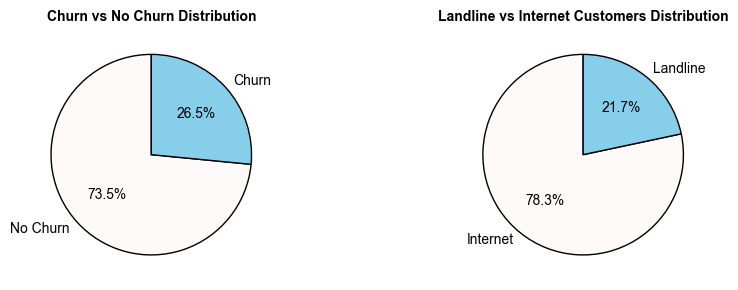

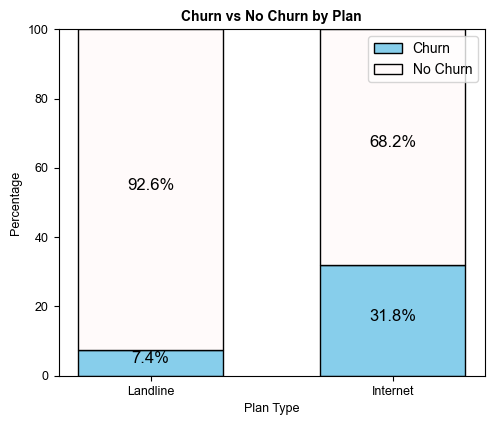

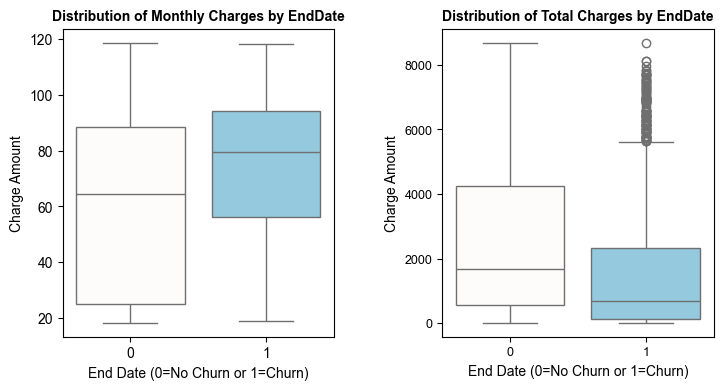

Outlier Percentage: 4.71%




In [68]:
#--------------------------------------------------------------#
                        # Pie Chart #
#--------------------------------------------------------------#

churn_counts = df['EndDate'].value_counts()

plan_counts = df['Plan'].value_counts()

colors = ['snow', 'skyblue']

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].pie(churn_counts, labels=churn_counts.index.map({0: 'No Churn', 1: 'Churn'}), 
            autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
axes[0].set_title('Churn vs No Churn Distribution', fontsize=10, fontweight='bold')

axes[1].pie(plan_counts, labels=plan_counts.index, autopct='%1.1f%%', startangle=90, 
            colors=colors, wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Landline vs Internet Customers Distribution', fontsize=10, fontweight='bold')

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial",
                                   "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]
plt.tight_layout()
plt.show()
print()

#--------------------------------------------------------------#
                        # Bar chart #
#--------------------------------------------------------------#
categories = ['Landline', 'Internet']

churn_counts = [
    ((df['Plan'] == 'Landline') & (df['EndDate'] == 1)).sum(),
    ((df['Plan'] == 'Internet') & (df['EndDate'] == 1)).sum(),
]

no_churn_counts = [
    ((df['Plan'] == 'Landline') & (df['EndDate'] == 0)).sum(),
    ((df['Plan'] == 'Internet') & (df['EndDate'] == 0)).sum(),
]

total_counts = [churn_counts[i] + no_churn_counts[i] for i in range(len(categories))]

churn_percent = [churn_counts[i] / total_counts[i] * 100 for i in range(len(categories))]
no_churn_percent = [no_churn_counts[i] / total_counts[i] * 100 for i in range(len(categories))]

bar_width = 0.6
x = np.arange(len(categories))

plt.figure(figsize=(5.5, 4.5))
plt.bar(x, churn_percent, width=bar_width, label='Churn', color='skyblue', edgecolor='black')
plt.bar(x, no_churn_percent, width=bar_width, label='No Churn', color='snow', edgecolor='black', bottom=churn_percent)

for i in range(len(categories)):
    plt.text(x[i], churn_percent[i] / 2, f"{churn_percent[i]:.1f}%", ha='center', color='black', fontsize=12)
    plt.text(x[i], churn_percent[i] + (no_churn_percent[i] / 2), f"{no_churn_percent[i]:.1f}%", ha='center', color='black', fontsize=12)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial",
                                   "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]


plt.xlabel('Plan Type', fontsize=9)
plt.ylabel('Percentage', fontsize=9)
plt.title('Churn vs No Churn by Plan', fontsize=10, fontweight='bold')
plt.xticks(ticks=x, labels=categories)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.ylim(0, 100)
plt.legend()

plt.show()
print()
#--------------------------------------------------------------#
                        # Boxplot #
#--------------------------------------------------------------#

fig, axes = plt.subplots(1, 2, figsize=(8.4, 4))

colors = ['snow', 'skyblue']

df_melted_monthly = df.melt(id_vars=['EndDate'], value_vars=['MonthlyCharges'], 
                            var_name='ChargeType', value_name='ChargeAmount')

df_melted_total = df.melt(id_vars=['EndDate'], value_vars=['TotalCharges'], 
                          var_name='ChargeType', value_name='ChargeAmount')

sns.boxplot(x='EndDate', y='ChargeAmount', data=df_melted_monthly, ax=axes[0], palette=colors)
axes[0].set_title('Distribution of Monthly Charges by EndDate', fontsize=10, fontweight='bold')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
axes[0].set_xlabel('End Date (0=No Churn or 1=Churn)')
axes[0].set_ylabel('Charge Amount')

sns.boxplot(x='EndDate', y='ChargeAmount', data=df_melted_total, ax=axes[1], palette=colors)
axes[1].set_title('Distribution of Total Charges by EndDate', fontsize=10, fontweight='bold')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
axes[1].set_xlabel('End Date (0=No Churn or 1=Churn)')
axes[1].set_ylabel('Charge Amount')

plt.subplots_adjust(wspace=0.4)

plt.show()

outlier = ((df['EndDate']==1) & (df['TotalCharges']>6000)).sum()
total = ((df['EndDate']==1) & (df['TotalCharges'])).sum()
outlier_percentage = outlier / total * 100 
print(f"Outlier Percentage: {outlier_percentage:.2f}%")
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial",
                                   "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]
print()
print()


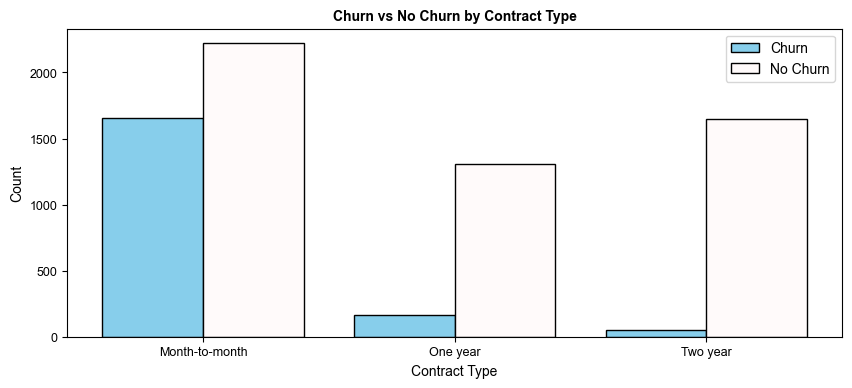

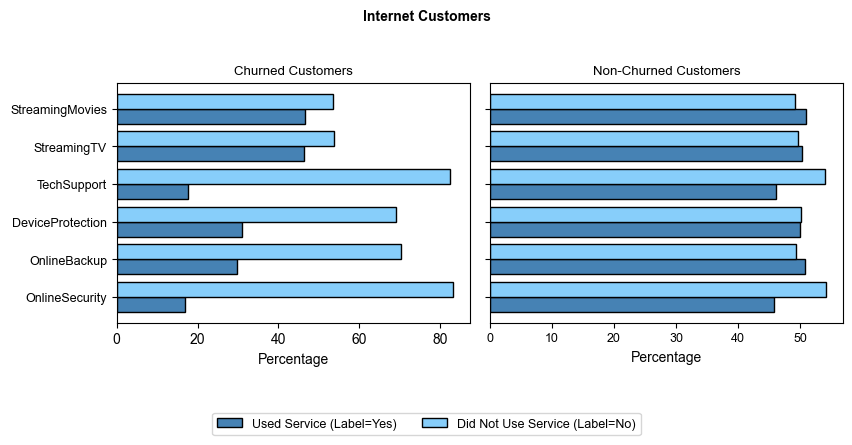

In [84]:
#--------------------------------------------------------------#
                        # Bar chart #
#--------------------------------------------------------------#
categories = ['Month-to-month', 'One year', 'Two year']

churn = [
    ((df['EndDate'] == 1) & (df['Type'] == 'Month-to-month')).sum(),
    ((df['EndDate'] == 1) & (df['Type'] == 'One year')).sum(),
    ((df['EndDate'] == 1) & (df['Type'] == 'Two year')).sum()
]

no_churn = [
    ((df['EndDate'] == 0) & (df['Type'] == 'Month-to-month')).sum(),
    ((df['EndDate'] == 0) & (df['Type'] == 'One year')).sum(),
    ((df['EndDate'] == 0) & (df['Type'] == 'Two year')).sum()
]

bar_width = 0.4

x = np.arange(len(categories))

plt.figure(figsize=(10, 4))
plt.bar(x - bar_width/2, churn, width=bar_width, label='Churn', color='skyblue', edgecolor='black')
plt.bar(x + bar_width/2, no_churn, width=bar_width, label='No Churn', color='snow', edgecolor='black')

plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.title('Churn vs No Churn by Contract Type', fontsize=10, fontweight='bold')
plt.xticks(ticks=x, labels=categories)
plt.legend()
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial",
                                   "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()
print()
#--------------------------------------------------------------#
                        # Stacked bar chart #
#--------------------------------------------------------------#

df_filtered = df[df['InternetService'] != 'None']

categories = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

churn_yes = [((df_filtered['EndDate'] == 1) & (df_filtered[service] == 'Yes')).sum() / 
             (df_filtered['EndDate'] == 1).sum() * 100 for service in categories]

churn_no = [((df_filtered['EndDate'] == 1) & (df_filtered[service] == 'No')).sum() / 
            (df_filtered['EndDate'] == 1).sum() * 100 for service in categories]

no_churn_yes = [((df_filtered['EndDate'] == 0) & (df_filtered[service] == 'Yes')).sum() / 
                (df_filtered['EndDate'] == 0).sum() * 100 for service in categories]

no_churn_no = [((df_filtered['EndDate'] == 0) & (df_filtered[service] == 'No')).sum() / 
               (df_filtered['EndDate'] == 0).sum() * 100 for service in categories]

bar_width = 0.4
y = np.arange(len(categories))

fig, axes = plt.subplots(1, 2, figsize=(8.63, 4), sharey=True)

axes[0].barh(y - bar_width / 2, churn_yes, height=bar_width, label='Used Service (Label=Yes)', color='steelblue', edgecolor='black')
axes[0].barh(y + bar_width / 2, churn_no, height=bar_width, label='Did Not Use Service (Label=No)', color='lightskyblue', edgecolor='black')
axes[0].set_title('Churned Customers', fontsize=9.5)
axes[0].set_xlabel('Percentage')
axes[0].set_yticks(y)
axes[0].set_yticklabels(categories, fontsize=9)

axes[1].barh(y - bar_width / 2, no_churn_yes, height=bar_width, label='Used Service (Label=Yes)', color='steelblue', edgecolor='black')
axes[1].barh(y + bar_width / 2, no_churn_no, height=bar_width, label='Did Not Use Service (Label=No)', color='lightskyblue', edgecolor='black')
axes[1].set_title('Non-Churned Customers', fontsize=9.5)
axes[1].set_xlabel('Percentage')
axes[1].set_yticks(y)
axes[1].set_yticklabels(categories)

fig.suptitle('Internet Customers', fontsize=10, fontweight='bold')
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial",
                                   "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=True, fontsize=9)

---
***Exploratory Data Analysis***:

- The datasets have different lengths but are interconnected through the customerID variable. To streamline the analysis, merging the datasets using customerID was preferred over analyzing them separately. This approach provides a more comprehensive view of the data.

- A check for duplicate entries in both the entire dataset and within the customerID column found no duplicates. Additionally, data types for several columns were corrected to ensure consistency. The EndDate column was transformed into a binary variable: 0 (no churn) and 1 (churn).

- An examination of missing values, zero entries, and blank cells revealed no missing values when analyzing each dataset individually. However, the merged dataset contained apparent missing values due to differences in dataset sizes. This discrepancy arises because some customerIDs exist in larger datasets but are absent in smaller ones. The majority of these missing values correspond to customers without information on internet services, indicating that they belong to the landline communication service.     

***Preliminary conclusion from EDA***:

- **Class Imbalance**: A pie chart revealed a significant class imbalance, with 74% of customers categorized as "no churn" and 26% as "churn." There's also class imbalance within internet customers (78% of the dataset). This imbalance could negatively impact machine learning models, as they may become biased toward the majority class. Proper techniques for handling class imbalance will be necessary.

- **Monthly vs. Total Charges**: Customers who churn tend to have higher median monthly charges compared to those who do not churn. However, their total charges tend to be lower, with more noticeable outliers. This suggests that churned customers may have shorter tenure periods and experience more volatile billing patterns.

- **Contract Type and Churn**: The majority of customers, both churned and non-churned, have month-to-month contracts. However, a disproportionately high number of churned customers are on this type of contract. This suggests that customers with flexible contracts are more likely to churn compared to those locked into one-year or two-year plans.

- **Service Usage and Churn**: Customers who churn are more likely to use streaming services such as movies and TV, while their engagement with other services is relatively low. In contrast, non-churned customers exhibit a more balanced distribution of service usage.

- **Churn by Customer Type**: Customers on the Internet service plan have a higher churn rate compared to those on the Landline plan, with 32% versus 7%, respectively.

⚠️ Note: Since the dataset is imbalanced, these insights may be biased toward customers who do not churn. Adjustments will be necessary to ensure fair representation.

***Plan for solving the task***:

1) **Data Preprocessing**: Since the dataset includes both categorical and numerical variables, all features will be converted into a unified format using ordinal encoding where necessary.

2) **Handling Class Imbalance**: Appropriate techniques such as class weighting, upsampling the churn class, or downsampling the no-churn class will be applied to ensure balanced model training.

3) **Model Selection**: Various machine learning models suitable for classification will be tested, including Random Forest, Decision Trees and Gradient Boosting.

4) **Model Training and Validation**:

    - The dataset will be split into training and test sets.
    - Selected models will be trained and validated using cross-validation and hyperparameter tuning.
    - Model evaluation will be based on the AUC-ROC metric, as per guidelines.
    - Threshold adjustment and feature importance analysis will be conducted to optimize model performance.

     
5) **Final Model Selection & Recommendations**:
    - The best-performing model will be trained using optimized hyperparameters.
    - Performance will be compared against a dummy model to ensure meaningful predictive power.
    - Insights will be generated on how to reduce customer churn based on model predictions.

### Data Preprocessing
---

#### Creating ordinal encoding

In [87]:
categorical_features = ['BeginDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService',
                        'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'gender', 'Partner', 'Dependents',
                        'Plan']                    
                       
df[categorical_features] = OrdinalEncoder().fit_transform(df[categorical_features])

#OBS: class imbalance will be addressed with Class Weight Adjustment in the next step (model training and validation).     

In [88]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Plan
0,7590-VHVEG,75.0,0,0.0,1.0,2.0,29.85,29.85,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0,0.0
1,5575-GNVDE,42.0,0,1.0,0.0,3.0,56.95,1889.50,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0,0.0
2,3668-QPYBK,72.0,1,0.0,1.0,3.0,53.85,108.15,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0,0.0
3,7795-CFOCW,31.0,0,1.0,0.0,0.0,42.30,1840.75,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0,0.0
4,9237-HQITU,71.0,1,0.0,1.0,2.0,70.70,151.65,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0


### Model Training and Validation
---


#### Creating features/target and scalling 

In [89]:
features = df.drop(['EndDate', 'customerID'], axis=1) 
target = df['EndDate']

features_train_valid, features_test, target_train_valid, target_test = train_test_split(features, target, test_size=0.20, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train_valid, target_train_valid, test_size=0.25, random_state=12345) 

features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)


#### Decision Tree

Best model: max_depth = 4, AUC-ROC: 82.56%, F1 score: 60.46%
Score Train: 76.99%, Score Valid: 75.59%
Recall score: 74.50%
Precision score: 50.87%
Threshold = 0.00 | F1 = 0.401, Precision = 0.251, Recall = 1.000
Threshold = 0.10 | F1 = 0.477, Precision = 0.315, Recall = 0.983
Threshold = 0.20 | F1 = 0.527, Precision = 0.367, Recall = 0.938
Threshold = 0.30 | F1 = 0.557, Precision = 0.402, Recall = 0.909
Threshold = 0.40 | F1 = 0.567, Precision = 0.414, Recall = 0.898
Threshold = 0.50 | F1 = 0.605, Precision = 0.509, Recall = 0.745
Threshold = 0.60 | F1 = 0.609, Precision = 0.522, Recall = 0.731
Threshold = 0.70 | F1 = 0.605, Precision = 0.537, Recall = 0.691
Threshold = 0.80 | F1 = 0.328, Precision = 0.946, Recall = 0.198
Threshold = 0.90 | F1 = 0.328, Precision = 0.946, Recall = 0.198



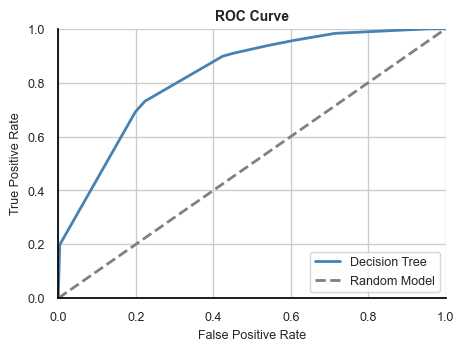

In [103]:
best_score = 0
best_depth = 0
rs_decision_tree = 0 
ps_decision_tree = 0

for depth in range(1, 5):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') 
    model.fit(features_train, target_train)
    predictions_valid_decision_tree = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    auc_roc_decision_tree = roc_auc_score(target_valid, probabilities_one_valid)    
    
    if auc_roc_decision_tree > best_score:
        best_score = auc_roc_decision_tree
        best_depth = depth
        rs_decision_tree = recall_score(target_valid, predictions_valid_decision_tree)
        ps_decision_tree = precision_score(target_valid, predictions_valid_decision_tree, zero_division=0)
        f1_decision_tree = f1_score(target_valid, predictions_valid_decision_tree)
        score_decision_tree_train = model.score(features_train, target_train)
        score_decision_tree_valid = model.score(features_valid, target_valid)
        
print(f"Best model: max_depth = {best_depth}, AUC-ROC: {best_score* 100:.2f}%, F1 score: {f1_decision_tree * 100:.2f}%")
print(f"Score Train: {score_decision_tree_train* 100:.2f}%, Score Valid: {score_decision_tree_valid* 100:.2f}%")
print(f"Recall score: {rs_decision_tree* 100:.2f}%")
print(f"Precision score: {ps_decision_tree* 100:.2f}%")

for threshold in np.arange(0, 1.0, 0.1):
    predictions_valid_decision_tree = (probabilities_one_valid >= threshold).astype(int)
    f1_decision_tree = f1_score(target_valid, predictions_valid_decision_tree)
    ps_decision_tree = precision_score(target_valid, predictions_valid_decision_tree)
    rs_decision_tree = recall_score(target_valid, predictions_valid_decision_tree)
    print('Threshold = {:.2f} | F1 = {:.3f}, Precision = {:.3f}, Recall = {:.3f}'.format(threshold, f1_decision_tree, ps_decision_tree, rs_decision_tree))
    
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
print()

sns.set_theme(style="whitegrid", palette="Blues")

plt.figure(figsize=(5, 3.5))

plt.plot(fpr, tpr, label='Decision Tree', color='steelblue', lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Model', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('ROC Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

#### Random Forest

Best model: max_depth = 9, n_estimators = 19, min_samples_split = 4, min_samples_leaf = 4, AUC-ROC: 86.31%, F1 score: 65.44%
Score Train: 85.18%, Score Valid: 80.06%
Recall score: 75.35%
Precision score: 57.83%
Threshold = 0.00 | F1 = 0.401, Precision = 0.251, Recall = 1.000
Threshold = 0.10 | F1 = 0.485, Precision = 0.324, Recall = 0.969
Threshold = 0.20 | F1 = 0.531, Precision = 0.373, Recall = 0.924
Threshold = 0.30 | F1 = 0.581, Precision = 0.436, Recall = 0.873
Threshold = 0.40 | F1 = 0.617, Precision = 0.492, Recall = 0.830
Threshold = 0.50 | F1 = 0.638, Precision = 0.563, Recall = 0.737
Threshold = 0.60 | F1 = 0.643, Precision = 0.631, Recall = 0.654
Threshold = 0.70 | F1 = 0.620, Precision = 0.715, Recall = 0.547
Threshold = 0.80 | F1 = 0.477, Precision = 0.786, Recall = 0.343
Threshold = 0.90 | F1 = 0.097, Precision = 0.947, Recall = 0.051



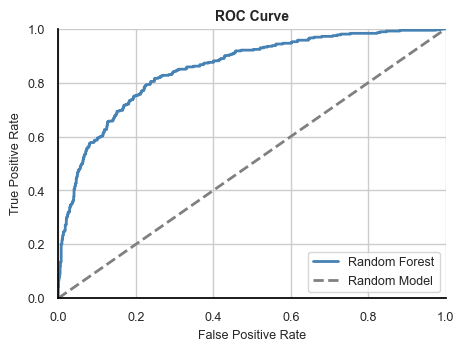

In [104]:
best_score = 0
best_depth = 0
rs_random_forest = 0 
ps_random_forest = 0

for depth in range(1, 10):
    for est in range(1, 20):
        for split in range(2,5):
            for leaf in range(1,5):
                model = RandomForestClassifier(random_state=12345, max_depth=depth, 
                                   class_weight='balanced', n_estimators=est, 
                                   min_samples_leaf=leaf, min_samples_split=split)

                model.fit(features_train, target_train)
                predictions_valid_random_forest = model.predict(features_valid)
                probabilities_valid = model.predict_proba(features_valid)
                probabilities_one_valid = probabilities_valid[:, 1]
                
                auc_roc_random_forest = roc_auc_score(target_valid, probabilities_one_valid)                                 

                if auc_roc_random_forest > best_score:
                    best_score = auc_roc_random_forest
                    best_depth = depth
                    rs_random_forest = recall_score(target_valid, predictions_valid_random_forest)
                    ps_random_forest = precision_score(target_valid, predictions_valid_random_forest, zero_division=0)
                    f1_random_forest = f1_score(target_valid, predictions_valid_random_forest)
                    score_random_forest_train = model.score(features_train, target_train)
                    score_random_forest_valid = model.score(features_valid, target_valid)
        
print(f"Best model: max_depth = {best_depth}, n_estimators = {est}, min_samples_split = {split}, min_samples_leaf = {leaf}, AUC-ROC: {best_score* 100:.2f}%, F1 score: {f1_random_forest * 100:.2f}%")
print(f"Score Train: {score_random_forest_train* 100:.2f}%, Score Valid: {score_random_forest_valid* 100:.2f}%")
print(f"Recall score: {rs_random_forest* 100:.2f}%")
print(f"Precision score: {ps_random_forest* 100:.2f}%")

for threshold in np.arange(0, 1.0, 0.1):
    predictions_valid_random_forest = (probabilities_one_valid >= threshold).astype(int)
    f1_random_forest = f1_score(target_valid, predictions_valid_random_forest)
    ps_random_forest = precision_score(target_valid, predictions_valid_random_forest)
    rs_random_forest = recall_score(target_valid, predictions_valid_random_forest)
    print('Threshold = {:.2f} | F1 = {:.3f}, Precision = {:.3f}, Recall = {:.3f}'.format(threshold, f1_random_forest, ps_random_forest, rs_random_forest))
    
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
print()

sns.set_theme(style="whitegrid", palette="Blues")

plt.figure(figsize=(5, 3.5))

plt.plot(fpr, tpr, label='Random Forest', color='steelblue', lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Model', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('ROC Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

#### Gradient Boosting

Best model: {'num_trees': 200, 'learning_rate': 0.05, 'max_depth': 5}, AUC-ROC: 88.64%, F1 score: 66.90%
Score Train: 83.83%, Score Valid: 80.20%
Recall score: 79.89%
Precision score: 57.55%
Threshold = 0.00 | F1 = 0.401, Precision = 0.251, Recall = 1.000
Threshold = 0.10 | F1 = 0.508, Precision = 0.344, Recall = 0.972
Threshold = 0.20 | F1 = 0.557, Precision = 0.395, Recall = 0.946
Threshold = 0.30 | F1 = 0.590, Precision = 0.436, Recall = 0.912
Threshold = 0.40 | F1 = 0.636, Precision = 0.504, Recall = 0.861
Threshold = 0.50 | F1 = 0.669, Precision = 0.576, Recall = 0.799
Threshold = 0.60 | F1 = 0.668, Precision = 0.640, Recall = 0.700
Threshold = 0.70 | F1 = 0.671, Precision = 0.747, Recall = 0.609
Threshold = 0.80 | F1 = 0.612, Precision = 0.865, Recall = 0.473
Threshold = 0.90 | F1 = 0.430, Precision = 0.990, Recall = 0.275



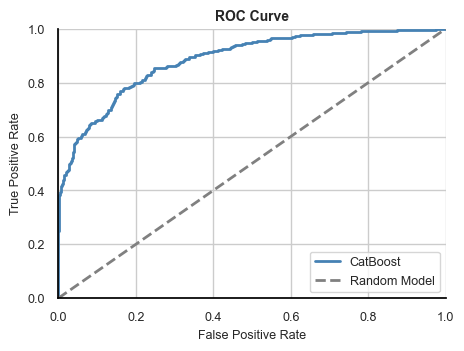

In [105]:
num_trees_range = [50, 100, 200]
learning_rate_range = [0.01, 0.05]
max_depth_range = [5, 10, 15]

best_score = 0
best_params = {}
best_probabilities = None
best_f1 = 0 
best_recall = 0 
best_precision = 0  

class_counts = Counter(target)
class_weight_ratio = class_counts[0] / class_counts[1]

for num_trees in num_trees_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            model_cat = CatBoostClassifier(
                iterations=num_trees, learning_rate=learning_rate, depth=max_depth,
                subsample=0.8, random_seed=12345, verbose=0, loss_function='Logloss', scale_pos_weight=class_weight_ratio)
            
            model_cat.fit(features_train, target_train, eval_set=(features_valid, target_valid), early_stopping_rounds=50)
            predictions_valid = model_cat.predict(features_valid)
            probabilities_valid = model_cat.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
            
            f1 = f1_score(target_valid, predictions_valid)
            recall = recall_score(target_valid, predictions_valid)
            precision = precision_score(target_valid, predictions_valid, zero_division=0)
            
            if auc_roc > best_score:
                best_score = auc_roc
                best_params = {'num_trees': num_trees, 'learning_rate': learning_rate, 'max_depth': max_depth}
                best_f1 = f1  
                best_recall = recall 
                best_precision = precision  
                score_train = model_cat.score(features_train, target_train)
                score_valid = model_cat.score(features_valid, target_valid)
                best_probabilities = probabilities_one_valid

print(f"Best model: {best_params}, AUC-ROC: {best_score* 100:.2f}%, F1 score: {best_f1 * 100:.2f}%")
print(f"Score Train: {score_train* 100:.2f}%, Score Valid: {score_valid* 100:.2f}%")
print(f"Recall score: {best_recall* 100:.2f}%")
print(f"Precision score: {best_precision* 100:.2f}%")

for threshold in np.arange(0, 1.0, 0.1):
    predictions_valid = (best_probabilities >= threshold).astype(int)
    f1 = f1_score(target_valid, predictions_valid)
    ps = precision_score(target_valid, predictions_valid)
    rs = recall_score(target_valid, predictions_valid)
    print('Threshold = {:.2f} | F1 = {:.3f}, Precision = {:.3f}, Recall = {:.3f}'.format(threshold, f1, ps, rs))
    
fpr, tpr, _ = roc_curve(target_valid, best_probabilities) 
print()

sns.set_theme(style="whitegrid", palette="Blues")

plt.figure(figsize=(5, 3.5))

plt.plot(fpr, tpr, label='CatBoost', color='steelblue', lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Model', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('ROC Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

#### Cross Validation using Gradient Boosting

In [106]:
class_counts = Counter(target)
class_weight_ratio = class_counts[0] / class_counts[1]

model_cross_val = CatBoostClassifier(random_state=0, verbose=0, scale_pos_weight=class_weight_ratio)
scores = cross_val_score(model_cross_val, features, target, cv=5, scoring="roc_auc")
final_score = scores.mean()
print(f'Average Cross Validation AUC-ROC score: {final_score * 100:.2f}%')

Average Cross Validation AUC-ROC score: 92.88%


#### Best Model (Gradient Boosting) using optimized hyperparameters on Test Set

In [107]:
class_counts = Counter(target)
class_weight_ratio = class_counts[0] / class_counts[1]

model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=5,
                subsample=0.8, random_seed=12345, verbose=0, loss_function='Logloss', scale_pos_weight=class_weight_ratio)
model.fit(features_train, target_train, eval_set=(features_test, target_test), early_stopping_rounds=50)
predictions_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]            
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'Best model AUC-ROC score: {auc_roc * 100:.2f}%')

Best model AUC-ROC score: 90.81%


#### Dummy Model

In [108]:
dummy = DummyClassifier(strategy="stratified")
dummy.fit(features_train, target_train)
prediction_dummy = dummy.predict(features_test)
probabilities_dummy = dummy.predict_proba(features_test)[:, 1] 
dummy_score = roc_auc_score(target_test, probabilities_dummy) 
print(f'Dummy AUC-ROC score: {dummy_score* 100:.2f}%')

Dummy AUC-ROC score: 49.74%


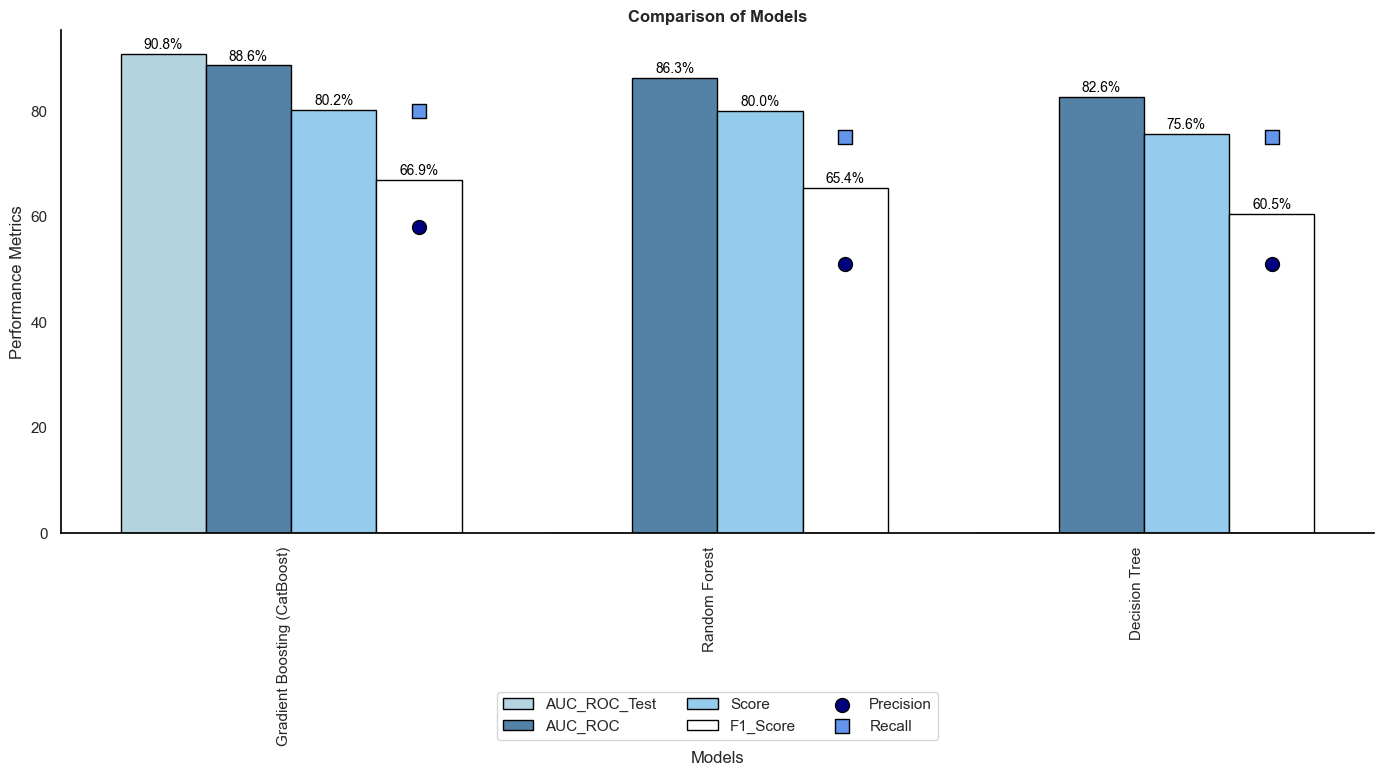

In [116]:
Models = ['Decision Tree', 'Random Forest', 'Gradient Boosting (CatBoost)']
AUC_ROC_Test = [0, 0, 90.8] 
AUC_ROC = [82.6, 86.3, 88.6]
F1_Score = [60.5, 65.4, 66.9]
Recall = [75, 75, 80]
Precision = [51, 51, 58]
Score = [75.6, 80.0, 80.2]

data = pd.DataFrame({
    'Models': Models, 
    'AUC_ROC_Test': AUC_ROC_Test, 
    'AUC_ROC': AUC_ROC, 
    'F1_Score': F1_Score, 
    'Score': Score, 
    'Recall': Recall, 
    'Precision': Precision
})
data = data.sort_values(by='AUC_ROC', ascending=False)

fig, ax = plt.subplots(figsize=(14, 8))
palette = {
    'AUC_ROC_Test': 'lightblue',
    'AUC_ROC': 'steelblue', 
    'Score': 'lightskyblue', 
    'F1_Score': 'white'
}
hue_order = ['AUC_ROC_Test', 'AUC_ROC', 'Score', 'F1_Score']

melted_data = data.melt(
    id_vars=['Models'], 
    value_vars=hue_order, 
    var_name='Metric', 
    value_name='Value'
)
sns.barplot(
    data=melted_data, 
    x='Models', 
    y='Value', 
    hue='Metric', 
    hue_order=hue_order,
    ax=ax, 
    palette=palette, 
    edgecolor='black'
)

offset = 0.3

group_centers = ax.get_xticks()

for i, center in enumerate(group_centers):
    x_f1 = center + offset
    ax.scatter(
        x_f1, data['Precision'].iloc[i],
        color='navy', marker='o', edgecolor='black',
        s=100, label='Precision' if i == 0 else ""
    )
    ax.scatter(
        x_f1, data['Recall'].iloc[i],
        color='cornflowerblue', marker='s', edgecolor='black',
        s=100, label='Recall' if i == 0 else ""
    )

# Increase annotation font size to 10 for labels on top of bars
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f'{p.get_height():.1f}%', 
            (p.get_x() + p.get_width() / 2, p.get_height() + 1),
            ha='center', fontsize=10, color='black'
        )

ax.set_xlabel('Models')
ax.set_ylabel('Performance Metrics')
ax.set_title('Comparison of Models', fontsize=12, fontweight='bold')
ax.set_xticklabels(data['Models'], rotation=90, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial",
                                   "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()

---
***Data Preprocessing***:

- The dataset includes both categorical and numerical features. To standardize the data, all categorical features were converted into numerical values using the ordinal encoding method, ensuring the dataset contains only numerical features.

***Model Training and Validation***:

- First, the dataset was split into train, validation and test, with the EndDate column set as the target variable to distinguish between churn and non-churn instances. Since the dataset contained features with varying scales, feature scaling was applied to ensure consistency across different attributes.

- Next, several models were trained and tested, including Decision Tree, Random Forest, Logistic Regression, and Gradient Boosting. A for loop was implemented to iterate over different hyperparameters, optimizing each model based on the AUC-ROC metric. Additionally, other performance metrics such as F1 score, accuracy, precision, and recall were analyzed. Class imbalance was addressed using the class weight adjustment function. The best-performing model was Gradient Boosting, achieving an AUC-ROC score of 88.6%, followed by Random Forest (86.3%), and Decision Tree (82.6%). Furthermore, Gradient Boosting ranked highest in terms of F1 score (66.9%), while its precision and recall outperformed the other models, demonstrating its effectiveness in accurately predicting churn and capturing more churn instances.

- To further validate its performance, Gradient Boosting was tested using cross-validation, with class imbalance adjustments applied via class weight ratios. The cross-validation results confirmed the model’s robustness, achieving an AUC-ROC of 93% (compared to 89% from the best-tuned model). When the best model was re-evaluated using the optimized hyperparameters on the test set, the results remained consistent (91%).

- For a sanity check, a Dummy model was used as a baseline comparison against Gradient Boosting. Since the Dummy model does not account for class imbalance, its results were skewed toward the majority class, leading to a poor AUC-ROC score of only 50%. This further confirmed the superior performance of Gradient Boosting.

- In conclusion, after evaluating multiple models, Gradient Boosting surpassed the highest AUC-ROC threshold of 88%, making it the most suitable model for Interconnect Telecom Operator to predict client churn. It achieved an AUC-ROC score, with an accuracy/F1 score of 80%/67%, respectively. Additionally, precision and recall were better balanced compared to the other models, solidifying its reliability.
   
- As the next step, a feature importance analysis will be conducted within the Gradient Boosting model. Alongside insights gained during exploratory data analysis (EDA), a solution report will be provided with recommendations for Interconnect Telecom Operator on strategies to mitigate potential client churn.

### Solution Report
---




***Main conclusions***:

The analysis highlights key factors influencing customer churn, revealing several critical patterns that can guide targeted retention strategies. Billing patterns play a crucial role in predicting churn. Customers who churn tend to have higher median monthly charges but lower total charges, indicating shorter tenure and more volatile spending behavior. This is reinforced by feature importance in the Gradient Boosting model (see below).

In addition, contract type is another critical predictor of churn. Month-to-month contracts suggest that flexible agreements lead to higher churn rates compared to one-year or two-year contracts. This aligns with tenure data, where longer customer relationships correspond with lower churn rates. This finding is also supported by feature importance scores, highlighting key variables with high significance.

Service usage patterns also indicate a trend—churned customers are more likely to use streaming services such as movies and TV, while non-churned customers tend to engage more evenly across different service offerings. This suggests that customers with more focused service usage may be at a higher risk of leaving.

Finally, churn rates vary significantly between customer types, with Internet service customers exhibiting a much higher churn rate (32%) than those on landline plans (7%). 

***Key strategies***:

Above discussion highlights the need for differentiated retention strategies based on service type:

- **Billing Optimization**: Offer personalized discounts, bundling, or installment plans to stabilize billing fluctuations for high-risk customers.

- **Contract Incentives**: Provide discounts and loyalty rewards for customers committing to longer-term contracts.

- **Enhanced Streaming Experience**: Improve content recommendations, streaming quality, and exclusive perks for engaged users.

- **Proactive Retention**: Strengthen onboarding targeting high-risk customers with tailored offers.

- **Service Bundling**: Promote bundled plans and enhance customer support to improve retention, especially for internet users.


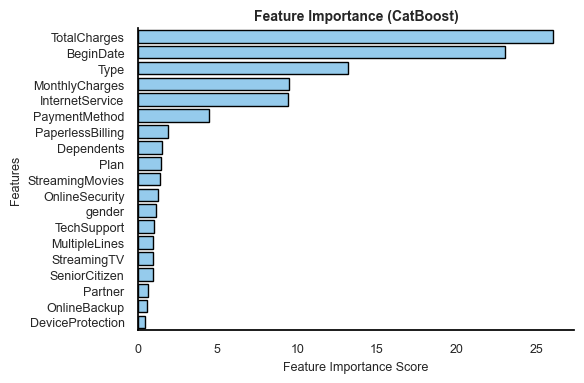

In [125]:
df_edit = df.drop(['customerID', 'EndDate'], axis=1)
feature_importance = model.get_feature_importance()
feature_names = df_edit.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

plt.figure(figsize=(6, 4))
ax = plt.gca()

sns.barplot(x='Importance', y='Feature', data=importance_df, color='lightskyblue', edgecolor='black', ax=ax)

plt.xlabel('Feature Importance Score', fontsize=9)
plt.ylabel('Features', fontsize=9)
plt.title('Feature Importance (CatBoost)', fontsize=10, fontweight='bold')

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

ax.grid(False)

plt.tight_layout()
plt.show()